<a href="https://colab.research.google.com/github/Mehak-shahani/my-projects-/blob/main/AI_Powered_Image_Captioning_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary libraries
!pip install tensorflow
!pip install pillow
!pip install numpy


In [ ]:
import numpy as np
import pandas as pd
import os
import json
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Add, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.inception_v3 import preprocess_input
import matplotlib.pyplot as plt
from tqdm import tqdm


In [ ]:
# Download MSCOCO 2014 Train/Val dataset (small subset for practice)
!wget http://images.cocodataset.org/zips/train2014.zip -P /content/
!wget http://images.cocodataset.org/zips/val2014.zip -P /content/
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip -P /content/

# Unzip the downloaded files
!unzip /content/train2014.zip -d /content/
!unzip /content/val2014.zip -d /content/
!unzip /content/annotations_trainval2014.zip -d /content/

# Check if files are downloaded and unzipped properly
!ls /content/train2014 | head  # Display first few files from train set
!ls /content/val2014 | head    # Display first few files from val set


Streaming output truncated to the last 5000 lines.
 extracting: /content/val2014/COCO_val2014_000000262466.jpg  
 extracting: /content/val2014/COCO_val2014_000000153055.jpg  
 extracting: /content/val2014/COCO_val2014_000000155312.jpg  
 extracting: /content/val2014/COCO_val2014_000000010440.jpg  
 extracting: /content/val2014/COCO_val2014_000000541108.jpg  
 extracting: /content/val2014/COCO_val2014_000000202503.jpg  
 extracting: /content/val2014/COCO_val2014_000000161308.jpg  
 extracting: /content/val2014/COCO_val2014_000000153013.jpg  
 extracting: /content/val2014/COCO_val2014_000000089924.jpg  
 extracting: /content/val2014/COCO_val2014_000000289842.jpg  
 extracting: /content/val2014/COCO_val2014_000000191226.jpg  
 extracting: /content/val2014/COCO_val2014_000000157465.jpg  
 extracting: /content/val2014/COCO_val2014_000000218224.jpg  
 extracting: /content/val2014/COCO_val2014_000000030548.jpg  
 extracting: /content/val2014/COCO_val2014_000000347422.jpg  
 extracting: /conte

In [ ]:
import os
import json

# Set the path to the MSCOCO data directory
coco_train_images_dir = "/content/train2014"
coco_val_images_dir = "/content/val2014"
annotations_file = "/content/annotations/captions_train2014.json"

# Load the annotations JSON file
with open(annotations_file, 'r') as f:
    coco_annotations = json.load(f)

# Check the structure of the annotations
print(json.dumps(coco_annotations['annotations'][:5], indent=4))  # Display first 5 annotations


[
    {
        "image_id": 318556,
        "id": 48,
        "caption": "A very clean and well decorated empty bathroom"
    },
    {
        "image_id": 116100,
        "id": 67,
        "caption": "A panoramic view of a kitchen and all of its appliances."
    },
    {
        "image_id": 318556,
        "id": 126,
        "caption": "A blue and white bathroom with butterfly themed wall tiles."
    },
    {
        "image_id": 116100,
        "id": 148,
        "caption": "A panoramic photo of a kitchen and dining room"
    },
    {
        "image_id": 379340,
        "id": 173,
        "caption": "A graffiti-ed stop sign across the street from a red car "
    }
]


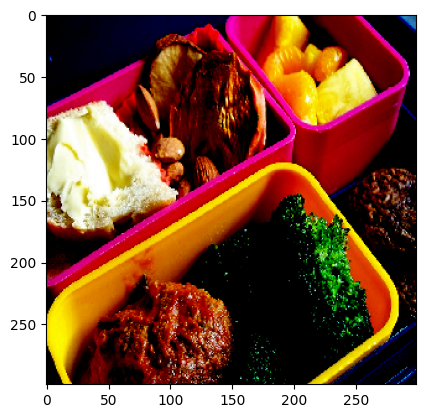

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Preprocess a sample image (resize and normalize for InceptionV3)
sample_image_path = '/content/train2014/COCO_train2014_000000000009.jpg'
img = load_img(sample_image_path, target_size=(299, 299))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Display the preprocessed image
plt.imshow(img_array[0])
plt.show()


In [ ]:
# Load InceptionV3 model pre-trained on ImageNet
inception_model = InceptionV3(include_top=False, weights='imagenet')

# Create a new model that outputs the features of the image
new_input = inception_model.input
hidden_layer = inception_model.layers[-1].output
feature_extractor = Model(inputs=new_input, outputs=hidden_layer)

# Function to extract features from an image
def extract_features(image_path):
    img = load_img(image_path, target_size=(299, 299))  # Resize image
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # Preprocess for InceptionV3
    feature = feature_extractor.predict(img_array)
    return feature


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Extract the image captions
captions = []
image_ids = []

# Loop through the annotations and extract captions
for annotation in coco_annotations['annotations']:
    captions.append(annotation['caption'])
    image_ids.append(annotation['image_id'])

# Create a DataFrame with image IDs and captions
import pandas as pd
captions_data = pd.DataFrame({'image_id': image_ids, 'caption': captions})

# Display first 5 rows of captions data
print(captions_data.head())


   image_id                                            caption
0    318556     A very clean and well decorated empty bathroom
1    116100  A panoramic view of a kitchen and all of its a...
2    318556  A blue and white bathroom with butterfly theme...
3    116100     A panoramic photo of a kitchen and dining room
4    379340  A graffiti-ed stop sign across the street from...


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenizer for captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions_data['caption'])  # Fit on all captions

# Convert captions to sequences of integers
sequences = tokenizer.texts_to_sequences(captions_data['caption'])

# Pad sequences to ensure they have the same length
max_length = max([len(sequence) for sequence in sequences])  # Get max length of caption
padded_sequences = pad_sequences(sequences, maxlen=max_length)

# Display tokenized and padded captions
print(f"Tokenized and padded sequences:\n{padded_sequences[:5]}")


Tokenized and padded sequences:
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     1  139  506    7  617  413  273   55]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    1 3989  168
     3    1   59    7  313    3  152  610]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    1   57
     7   19   55    6 2932 1959  133 1219]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0 

In [ ]:
# Function to extract features from an image
def extract_image_features(image_path):
    # Load the image and resize it to the input size for InceptionV3 (299x299)
    image = load_img(image_path, target_size=(299, 299))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = tf.keras.applications.inception_v3.preprocess_input(image)

    # Get the image features from InceptionV3
    features = inception_model.predict(image)
    return features

# Example usage: extract features for the first image in the dataset
# Get the image file name from the annotations
image_id = coco_annotations['annotations'][0]['image_id']  # First image's ID from annotations
image_filename = f"COCO_train2014_{image_id:012d}.jpg"  # Construct the image filename
image_path = os.path.join(coco_train_images_dir, image_filename)  # Full image path

# Extract image features
features = extract_image_features(image_path)

# Display the shape of the extracted features
print(f"Extracted features shape: {features.shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Extracted features shape: (1, 2048)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Add, Input

# Define the input layers
image_input = Input(shape=(features.shape[1],))  # Features extracted from InceptionV3
caption_input = Input(shape=(max_length,))  # Padded sequences of captions

# Image feature model (fully connected layer)
image_model = Dense(256, activation='relu')(image_input)

# Caption model (embedding and LSTM)
caption_model = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=256, mask_zero=True)(caption_input)
caption_model = LSTM(256)(caption_model)

# Merge image and caption models
merged_model = Add()([image_model, caption_model])
output = Dense(len(tokenizer.word_index) + 1, activation='softmax')(merged_model)

# Compile the model
captioning_model = Model(inputs=[image_input, caption_input], outputs=output)
captioning_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display model summary
captioning_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 50)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 2048)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 50, 256)        │      6,062,592 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 50)             │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        524,544 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 256)            │        525,312 │ embedding[0][0],       │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256)            │              0 │ dense[0][0],           │
│                           │                        │                │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 23682)          │      6,086,274 │ add[0][0]              │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 13,198,722 (50.35 MB)

 Trainable params: 13,198,722 (50.35 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Extract image features for all images and save them in a dictionary
image_features = {}

for annotation in coco_annotations['annotations']:
    image_id = annotation['image_id']
    image_filename = f"COCO_train2014_{image_id:012d}.jpg"  # Construct the image filename
    image_path = os.path.join(coco_train_images_dir, image_filename)  # Full image path

    if image_id not in image_features:  # Only extract features if not done already
        features = extract_image_features(image_path)  # Extract features
        image_features[image_id] = features  # Save the features

# Optionally, save the extracted features to a file for future use
import pickle
with open('/content/image_features.pkl', 'wb') as f:
    pickle.dump(image_features, f)

# Check the shape of extracted features for one image
sample_image_id = coco_annotations['annotations'][0]['image_id']
print(f"Shape of features for image {sample_image_id}: {image_features[sample_image_id].shape}")


Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━

In [ ]:
# Prepare data for training
def prepare_data_for_training(captions_data, image_features, max_length):
    X_image, X_caption, y = [], [], []

    for data in captions_data.itertuples():
        image_id = data.image_id
        caption = data.caption

        # Convert caption to sequence
        caption_sequence = tokenizer.texts_to_sequences([caption])[0]
        caption_sequence = pad_sequences([caption_sequence], maxlen=max_length)[0]

        # Extract image features for the image
        image_feature = image_features[image_id].flatten()  # Flatten the feature vector

        # Generate training data for each token in the caption
        for i in range(1, len(caption_sequence)):
            X_image.append(image_feature)
            X_caption.append(caption_sequence[:i])  # Caption up to the i-th token
            y.append(caption_sequence[i])  # The next token in the caption

    # Convert lists to numpy arrays
    X_image = np.array(X_image)
    X_caption = np.array(X_caption)
    y = np.array(y)

    return X_image, X_caption, y

# Prepare the data for training
X_image, X_caption, y = prepare_data_for_training(captions_data, image_features, max_length)

# Check the shape of the prepared data
print(f"X_image shape: {X_image.shape}")
print(f"X_caption shape: {X_caption.shape}")
print(f"y shape: {y.shape}")


In [ ]:
# Train the model
captioning_model.fit([X_image, X_caption], y, epochs=10, batch_size=64, verbose=1)

# Save the trained model for future use
captioning_model.save('/content/captioning_model.h5')

# Optionally, print a summary of the trained model
captioning_model.summary()


In [ ]:
# Function to generate a caption for an image
def generate_caption(image_path, model, max_length, tokenizer):
    # Extract image features
    features = extract_image_features(image_path)

    # Start the caption generation with the start token
    caption = [tokenizer.word_index['startseq']]

    for _ in range(max_length):
        # Pad the sequence to the required length
        sequence = pad_sequences([caption], maxlen=max_length)

        # Predict the next word (token)
        yhat = model.predict([features, sequence], verbose=0)
        yhat = np.argmax(yhat)

        # If the predicted word is the end token, stop the generation
        if yhat == tokenizer.word_index['endseq']:
            break

        # Add the predicted word to the caption
        caption.append(yhat)

    # Convert the tokenized caption back to words
    caption_words = [word for word, index in tokenizer.word_index.items() if index == word_id for word_id in caption]

    return ' '.join(caption_words[1:-1])  # Exclude startseq and endseq tokens

# Example usage: generate a caption for a new image
new_image_path = '/content/train2014/COCO_train2014_000000000009.jpg'
generated_caption = generate_caption(new_image_path, captioning_model, max_length, tokenizer)
print(f"Generated caption: {generated_caption}")
